In [143]:
import pandas as pd
import numpy as np
#import argparse
import cv2, csv, glob, os, sys
import pickle
import scipy.spatial as sps
import pdb
import time
from matplotlib import pyplot as plt

In [218]:
%gui qt
%matplotlib notebook

In [185]:
#Run norm_videos.py first.

COLOR_BOUND = {
'blue':((0,50,0), (130,225,136)),\
'red': ((0,100,70), (10,255,255)),\
'yellow': ((13,100,100),(24,255,255))
}
#'yellow'20:31
#red 0:12
color_loc = {
'red': [],\
'blue': [],\
'yellow': [],\
}

color_data = {
'yellow_output': [],\
'red_output':[],\
}

frameCenter = []
setColor = []
setColorMin = []
setColorMax = []
refPt = np.zeros((4))
position = []

firstFrame = True

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))

In [5]:
def histNorm(frame,plotting=False):	
	"""this function does some shit
	Frame must be cropped (tracking area only)"""

	hist, bins = np.histogram(frame.flatten(),256,[0,256])
	
	cdf = hist.cumsum()
	cdf_normalized = cdf * hist.max()/cdf.max()
	
	if plotting:
		plt.plot(cdf_normalized, color = 'b')
		plt.hist(frame.flatten(),256,[0,256])
		plt.xlim([0,256])
		plt.legend(('cdf','histogram'), loc = 'upper left')
		plt.show()
		
		#TODO: delete image with keystroke
	
	#mask and scale histogram
	cdf_m = np.ma.masked_equal(cdf,0)
	cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
	cdf = np.ma.filled(cdf_m,0).astype('uint8')
	
	new_image = cdf[frame]
	
	return new_image

In [181]:
#NO TRACKING PREDICTION
class colortracker():#, numcolor=1, colornames='blue', tracers = 'off'):
	"""Finds object of specified color(s), tracks pixel position and 
		radius of the largets object in the frame.

	Attributes:
		colornames: user-specified colors to track (red,green,blue)
		tracers: draw trails of tracked points on image (may slow tracking)
		position: (x,y) pixel position of center of largest centroid
		radius: pixel radius of largest centroid
	"""
	
#	if numcolor is None:
#		numcolor = raw_input('Specify number of colors to track. ')
#	elif len(colornames) != numcolor:
#		print('Please specify the correct number of color names to track')
#		colornames = str(raw_input('Enter % color names: ') %numcolor) 

	def __init__(self, color, camera, flag, draw='on',tracers='off'):
		#Thread.__init__(self)
		#global color#global imported
		self.color = color
		self.draw = draw
		self.tracers = tracers
		self.position = []
		self.radius = []
		self.hsv_lower = np.uint8(COLOR_BOUND[color][0])
		self.hsv_upper = np.uint8(COLOR_BOUND[color][1])
		self.found = []
		self.camera = camera
		self.flag = flag
		self.csvname = []
		self.loadfilename = filename[:-4] + '_data.p'

		self.refPt = []
		self.sizePt = []
        
		self.imported = False

		if tracers != 'off':
			cv2.cvNamedWindow('Tracking video',1)

		#Make output file
		self.savefilename = str(filename[:-4]) + '.p'
		saveit = open(self.savefilename, 'wb')
				
	def import_settings(self):
		"""Asks user if image settings should be updated for specific color (determined by Thread). If yes, updates color
		center, reference region and crops image. If no, looks for save file of setting data then bypasses all setting 
		updates. BYPASSING SETTING UPDATES IS NOT RECOMMENDED. YOUR SHIT WILL EXPLODE."""
		global param_data, upperPt, lowerPt, frameCenter, refPt, frame		
				
		param_data = {
		'red_pos': [],\
		'red_min': [],\
		'red_max': [],\
		'yellow_pos': [],\
		'yellow_min': [],\
		'yellow_max': [],\
		'lowerPt': [],\
		'upperPt': [],\
		'frameCenter': [],\
		'refPt': [],\
		}
					
		param_data = pickle.load(open(self.loadfilename,"rb"))

		#TODO: only reference param_data, get rid of these variables
		upperPt = param_data['upperPt']
		lowerPt = param_data['lowerPt']
		frameCenter = param_data['frameCenter']
		refPt = param_data['refPt']
		
		#TODO: make this another class?
		
		self.hsv_lower = np.uint8(COLOR_BOUND[self.color][0])
		self.hsv_upper = np.uint8(COLOR_BOUND[self.color][1])
		
#		self.hsv_lower = np.uint8(param_data[self.color+'_min'])
#		self.hsv_upper = np.uint8(param_data[self.color+'_max'])
		
		#check for error in finding colors, set to canonical values
		if self.hsv_lower[0]==self.hsv_upper[0]:
			self.hsv_lower = np.uint8(COLOR_BOUND[self.color][0])
			self.hsv_upper = np.uint8(COLOR_BOUND[self.color][1])
		
		self.imported = True
		print('Settings imported')
		#return frame	
			
	def search_region(self,frame, color, regionSize=100):	#make this a hidden method?
		"""Creates region in which colors will be searched based on last-found position. 
		Outputs adjusted frame (frame) and top left corner of the search region (topleft)"""
		global searchCenter, brightness, contrast
		topleft = []

		#resize video and adjust color
		frame = frame[upperPt[1]:lowerPt[1],upperPt[0]:lowerPt[0]]
		#frame = histNorm(frame)
		frame = adjBrtCont(frame,brightness,contrast)
		#import pdb; pdb.set_trace()
        
		searchCenter = self.position[-1]
		#print searchCenter
        
		if isinstance(searchCenter, int):
			searchCenter = list(self.position)
		elif isinstance(searchCenter, tuple):
			searchCenter = list(self.position[-1])
		elif not isinstance(searchCenter[0],int):            
			#make sure values are int
			searchCenter = [int(i) for i in self.position[-1]]
            
		if searchCenter == (0,0) or searchCenter==(np.nan, np.nan) or not searchCenter:
			#If the point wasn't found in the previous frame, search the whole frame
			topleft = (0,0)
            
		else:
			topleft = (searchCenter[0] - regionSize/2, searchCenter[1]-regionSize/2)					
			frame = frame[searchCenter[1]-regionSize/2:searchCenter[1]+regionSize/2, searchCenter[0]-regionSize/2:searchCenter[0]+regionSize/2]

		return frame,topleft
	
	def find_color(self,frame):
		global hsv, color_data, upperPt, lowerPt		
		#TODO:Somewhere outside of this function, determine if from camera or file
		#firstFrame = False	
        
		if not self.imported: #camera.get(cv2.CAP_PROP_POS_FRAMES) == 1:
			#print('importing settings')
			self.import_settings()
			self.found = list(param_data[self.color+'_pos'])
			searchCenter = list(param_data[self.color+'_pos'])
			firstFrame = True
			other = (np.nan,np.nan)
			self.imported = True

			if self.color == 'yellow':
				self.position = list(param_data['yellow_pos'])
			else: #self.color == 'red':
				self.position = list(param_data['red_pos'])
				
			if not self.position:
				print('No position data!')

		#define search region
		frame,cropRef = self.search_region(frame,self.color)
		
		hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
	
		#filter image for specific color
		mask = cv2.inRange(hsv, self.hsv_lower, self.hsv_upper)
		mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)    #this function erodes and dilates based on kernel

		#import pdb; pdb.set_trace()		
		
		#for i in range(400):
		#camera.set(cv2.CAP_PROP_POS_FRAMES,400)
		#(grabbed, frame)=camera.read()
        
		#find contours in mask
		contours = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
        
		if len(contours) > 0:
            #Find center of largest contour
			filtered = max(contours, key=cv2.contourArea)

			((x, y), radius) = cv2.minEnclosingCircle(filtered)
			M = cv2.moments(filtered)
			center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

			if radius > 3: 
			# draw the circle and centroid on the frame,
			# then update the list of tracked points
				if self.color =='yellow':
					cv2.circle(frame, (int(x), int(y)), int(radius),
						(0, 255,255), 2)
				else:
					cv2.circle(frame, (int(x), int(y)), int(radius),
						(0,0,255),2)
				self.position.append([x+cropRef[0],y+cropRef[1]])
				self.found = self.position[-1]
				self.radius.append(radius)
			else:
				print('Object too small')
				self.position.append([np.nan, np.nan])
				self.radius.append(np.nan)
		else:
			print('{} object not found'.format(self.color))
			x = y = 0 #np.nan
			radius = 0# np.nan								
			self.position.append([0,0])#(np.nan, np.nan))
			self.radius.append(0) #previously np.nan

		#Dump data to pickle 
		#TODO: this is not fast, augment for live tracking ish
		color_data[self.color+'_output'].append((self.position[-1], self.radius[-1]))
		pickle.dump(color_data,open(self.savefilename,'wb'))

		cv2.imshow("tracking...",frame)
		cv2.imshow("mask",mask)
		if (cv2.waitKey(10) >= 0):
		#alternate:
#		if cv2.waitKey(10) & 0xFF == ord('q'):
			camera.release()
			cv2.destroyAllWindows()

In [86]:
#os.chdir('/Users/sazamore/BehaviorVids/')
ID = "90_170201_5rpm.mp4"#str(raw_input('Enter animal ID number: ')) + '_28nov16_1rpm.mp4'
filename = ID
camera = cv2.VideoCapture(filename)

cv2.namedWindow("tracking", cv2.WINDOW_AUTOSIZE)
red = colortracker("red",camera,1)
yellow = colortracker("yellow",camera,1)

camera.set(cv2.CAP_PROP_POS_FRAMES, 300)
g,frame = camera.read()
if g:
    scale = 1300./frame.shape[1]
    frame = cv2.resize(frame,None,fx=scale,fy=scale,interpolation = cv2.INTER_CUBIC)

In [58]:
upperPt = param_data['upperPt']
lowerPt = param_data['lowerPt']

In [11]:
#grabbed,frame = camera.read()
#yellow.import_settings()
#frame = cv2.resize(frame,None,fx=scale,fy=scale,interpolation = cv2.INTER_CUBIC)
#frame = frame[upperPt[1]:lowerPt[1],upperPt[0]:lowerPt[0]]

#cv2.imshow('Color input image', frame)
#cv2.imshow('Histogram equalized', img_output)
global brightness, contrast
brightness = 1.5 #1.65
contrast = -2. #-56.

def adjBrtCont(img,brightness=2.,contrast=-50.):
    mod_img = cv2.add(img,np.array([contrast]))
    mod_img = cv2.multiply(mod_img,np.array([brightness]))
    return mod_img

def drawMatchColor(img):
    """Draws circles on image for color matching. Color values are BGR. To make conversions, 
    use http://http://colorizer.org/. Remember to update the image (run this function)
    after every whole-image modification, or color values will also change."""
    x1,y1 = param_data['red_pos']
    cv2.circle(img, (int(x1)+10, int(y1)-10), int(5),(21.32, 36.47,203),-2)#(2.5, 206.5, 204), 2)
    
    x2,y2 = param_data['yellow_pos']
    cv2.circle(img, (int(x2)+10, int(y2)-10), int(5),(0, 183, 255),-2)#(21.5, 255, 127.5), 2)

def img_adj(frame):
    """On-screen live adjustment of brightness and contrast."""
    brightness = 1.5
    contrast = -2.

    finished = False
    mod_img = frame[:]
    prime_img = frame[:]
    #prime_img = cv2.add(prime_img,np.array([contrast])) 
    #prime_img = cv2.multiply(prime_img,np.array([brightness]))
        
    cv2.imshow('mod',mod_img)
    
    while not finished:
        mod_img = adjBrtCont(prime_img,brightness, contrast)
        #mod_img = cv2.add(prime_img,np.array([contrast]))
        #mod_img = cv2.multiply(mod_img,np.array([brightness]))
        drawMatchColor(mod_img)
        cv2.imshow('mod',mod_img)

        k = cv2.waitKey(0)
        if k == ord('w'): #up arrow key increases contrast
            contrast -= 2.
            mod_img = cv2.add(prime_img,np.array([contrast])) 
            
        elif k == ord('s'): #down arrow key decreases contrast
            contrast += 2.
            mod_img = cv2.add(prime_img,np.array([contrast])) 
            #cv2.imshow('mod',mod_img)
            #k = cv2.waitKey()
            
        elif k == ord('a'): #left arrow key decreases brightness
            brightness -= 0.05
            mod_img = cv2.multiply(prime_img,np.array([brightness]))
            #cv2.imshow('mod',mod_img)
            #k = cv2.waitKey()
            
        elif k == ord('d'): #right arrow key increases brightness
            brightness += 0.05
            mod_img = cv2.divide(prime_img,np.array([brightness]))
            #cv2.imshow('mod',mod_img)
            
            #k = cv2.waitKey()
        elif k == ord('o'): #show original
            cv2.imshow('original',frame)
            #k = cv2.waitKey()
        elif k == ord('x'): #d exits adjustment
            #ex = input('Are you sure? (Y/n) ')
            #if ex.lower == 'y':
                #continue
            #else:
            finished = True
            #x,y = param_data['red_pos']
            #red = 
            cv2.destroyAllWindows()
                #TODO: get color values at color loc

    return brightness, contrast

def update_colors(frame, brightness,contrast):
    """Updates upper and lower HSV values for masking"""
    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    x1,y1 = param_data['red_pos']
    red = hsv[y1-2:y1+2,x1-2:x1+2,:]
    red = np.uint8(red)
    redMin = (np.min(red[:,:,0]),np.min(red[:,:,1]),np.min(red[:,:,2]))	 	#not sure this will gake min of each column
    redMax = (np.max(red[:,:,0]),np.max(red[:,:,1]),np.max(red[ :,:,2]))
    
    x2,y2 = param_data['yellow_pos']
    yellow = hsv[y2-2:y2+2,x2-2:x2+2,:]
    yellow = np.uint8(yellow)
    yellowMin = (np.min(yellow[:,:,0]),np.min(yellow[:,:,1]),np.min(yellow[:,:,2]))	 	#not sure this will gake min of each column
    yellowMax = (np.max(yellow[:,:,0]),np.max(yellow[:,:,1]),np.max(yellow[ :,:,2]))
    
    return np.uint8(redMin), np.uint8(redMax), np.uint8(yellowMin), np.uint8(yellowMax)


In [182]:
cv2.destroyAllWindows()

In [41]:
#get param_data
yellow = colortracker("yellow",camera,1)
yellow.import_settings()
param_data

Settings imported


{'diameter': [],
 'frameCenter': (329, 340),
 'lowerPt': (990, 699),
 'red_max': (10, 255, 123),
 'red_min': (1, 213, 4),
 'red_pos': (382, 295),
 'refPt': [(44, 9), (124, 89)],
 'upperPt': (309, 24),
 'yellow_max': (16, 252, 240),
 'yellow_min': (2, 246, 83),
 'yellow_pos': (386, 305)}

In [186]:
camera.set(cv2.CAP_PROP_POS_FRAMES, 556)
grabbed,frame = camera.read()

frame = cv2.resize(frame,None,fx=scale,fy=scale,interpolation = cv2.INTER_CUBIC)
frame = frame[upperPt[1]:lowerPt[1],upperPt[0]:lowerPt[0]]

In [187]:
#bright,contr=img_adj(frame)
mod_img = adjBrtCont(frame,bright,contr)
cv2.imshow('mod',mod_img)

In [136]:
brightness = bright; contrast = contr

In [188]:
mask_check(mod_img)

In [180]:
#QUICK CHECK

#mod_img = cv2.add(frame,np.array([contrast]))
#mod_img = cv2.multiply(mod_img,np.array([brightness]))

def mask_check(mod_img):
    """Filters for yellow and red colors in augmented image ("mod_img"). Comparison to original ("frame") can be 
    made, but modifications to script are necessary. Displays augmented image with locations of "found" colors, 
    and images of masks for yellow and red colors. If the colors are well defined, there should be only small circle
    for red and yellow in the mask, and appropriately sized circles around the found colors on the input image 
    (mod_img)."""
    hsv_mod = cv2.cvtColor(mod_img, cv2.COLOR_BGR2HSV)
    #hsv_raw = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    #'red': ((0,100,70), (10,255,255)),\
    #'yellow': ((12,100,100),(31,255,255))

    #check updated color masks
    red_mask = cv2.inRange(hsv_mod, (0,100,70),(9,255,255))#red_min, red_max)
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel) 

    yellow_mask = cv2.inRange(hsv_mod, (12,100,100),(26,255,255))#yellow_min, yellow_max)
    yellow_mask = cv2.morphologyEx(yellow_mask, cv2.MORPH_OPEN, kernel) 

    contours = cv2.findContours(red_mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
    #pdb.set_trace()
    if contours:
        filtered = max(contours, key=cv2.contourArea)
        ((x, y), radius) = cv2.minEnclosingCircle(filtered)
        M = cv2.moments(filtered)
        center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
        cv2.circle(mod_img, (int(x), int(y)), int(radius),
                                        (0, 0, 255), 2)
    else:
        print('No yellow found')

    contours = cv2.findContours(yellow_mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
    filtered = max(contours, key=cv2.contourArea)
    ((x, y), radius) = cv2.minEnclosingCircle(filtered)
    M = cv2.moments(filtered)
    center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
    cv2.circle(mod_img, (int(x), int(y)), int(radius),
                                        (0, 255, 255), 2)

    cv2.imshow('image',mod_img)
    cv2.imshow('red mask',red_mask)
    cv2.imshow('yellow mask',yellow_mask)


In [189]:
for filename in glob.glob(ID):	
	global filename
	camera = cv2.VideoCapture(filename)

	#TODO:figure out live camera capture business. NEEDED?
	#TODO: toggle tracking "preview" (showing the tracking as it's happening)
	cv2.namedWindow("tracking", cv2.WINDOW_AUTOSIZE)
	camera.set(cv2.CAP_PROP_POS_FRAMES, 400)

	red = colortracker("red",camera,1)
	yellow = colortracker("yellow",camera,1)

	while True:
		#grab and scale frame
		(grabbed, frame) = camera.read()	#check args for filename
		#print('Frame {}'.format(camera.get(cv2.CAP_PROP_POS_FRAMES)))
		#import pdb; pdb.set_trace()
		scale = 1300./frame.shape[1]
		frame = cv2.resize(frame,None,fx=scale,fy=scale,interpolation = cv2.INTER_CUBIC)

		yellow.find_color(frame)
		time.sleep(.2)
		red.find_color(frame)
			#blue.find_color(frame)
#			if cv2.waitKey(10) >= 0:
#				camera.release()
#				cv2.destroyAllWindows()
#				print('Quitting tracker..')
#				sys.exit(1)

<ipython-input-189-a890181d1e08>:2: SyntaxWarning: name 'filename' is assigned to before global declaration
  global filename


Settings imported
Settings imported
Object too small


ValueError: cannot convert float NaN to integer

In [220]:
camera.get(cv2.CAP_PROP_POS_FRAMES)


620.0

In [162]:
class colortracker():#, numcolor=1, colornames='blue', tracers = 'off'):
	"""Finds object of specified color(s), tracks pixel position and 
		radius of the largets object in the frame.

	Attributes:
		colornames: user-specified colors to track (red,green,blue)
		tracers: draw trails of tracked points on image (may slow tracking)
		position: (x,y) pixel position of center of largest centroid
		radius: pixel radius of largest centroid
	"""
	
#	if numcolor is None:
#		numcolor = raw_input('Specify number of colors to track. ')
#	elif len(colornames) != numcolor:
#		print('Please specify the correct number of color names to track')
#		colornames = str(raw_input('Enter % color names: ') %numcolor) 

	def __init__(self, color, camera, flag, draw='on',tracers='off'):
		#Thread.__init__(self)
		#global color#global imported
		self.color = color
		self.draw = draw
		self.tracers = tracers
		self.position = []
		self.radius = []
		self.hsv_lower = np.uint8(COLOR_BOUND[color][0])
		self.hsv_upper = np.uint8(COLOR_BOUND[color][1])
		self.found = []
		self.camera = camera
		self.flag = flag
		self.csvname = []
		self.loadfilename = filename[:-4] + '_data.p'

		self.refPt = []
		self.sizePt = []
		
		
		self.velocity = (0,0)		
		#self.next = (0,0)
		#self.factor = 1
        
		self.imported = False

		if tracers != 'off':
			cv2.cvNamedWindow('Tracking video',1)

		#Make output file
		self.savefilename = str(filename[:-4]) + '.p'
		saveit = open(self.savefilename, 'wb')
				
	def import_settings(self):
		"""Asks user if image settings should be updated for specific color (determined by Thread). If yes, updates color
		center, reference region and crops image. If no, looks for save file of setting data then bypasses all setting 
		updates. BYPASSING SETTING UPDATES IS NOT RECOMMENDED. YOUR SHIT WILL EXPLODE."""
		global param_data, upperPt, lowerPt, frameCenter, refPt, frame		
				
		param_data = {
		'red_pos': [],\
		'red_min': [],\
		'red_max': [],\
		'yellow_pos': [],\
		'yellow_min': [],\
		'yellow_max': [],\
		'lowerPt': [],\
		'upperPt': [],\
		'frameCenter': [],\
		'refPt': [],\
		}
					
		param_data = pickle.load(open(self.loadfilename,"rb"))

		#TODO: only reference param_data, get rid of these variables
		upperPt = param_data['upperPt'][0]
		lowerPt = param_data['lowerPt'][0]
		frameCenter = param_data['frameCenter']
		refPt = param_data['refPt']
		
		#TODO: make this another class?
		
		self.hsv_lower = np.uint8(COLOR_BOUND[self.color][0])
		self.hsv_upper = np.uint8(COLOR_BOUND[self.color][1])
		
#		self.hsv_lower = np.uint8(param_data[self.color+'_min'])
#		self.hsv_upper = np.uint8(param_data[self.color+'_max'])
		
		#check for error in finding colors, set to canonical values
		if self.hsv_lower[0]==self.hsv_upper[0]:
			self.hsv_lower = np.uint8(COLOR_BOUND[self.color][0])
			self.hsv_upper = np.uint8(COLOR_BOUND[self.color][1])
		
		self.imported = True
		print('Settings imported')
		return frame	
			
	def search_region(self,frame, color, regionSize=100):	#make this a hidden method?
		"""Creates region in which colors will be searched based on last-found position. 
		Outputs adjusted frame (frame) and top left corner of the search region (topleft)"""
		global searchCenter
		topleft = []

		#resize video and adjust color
		frame = frame[upperPt[1]:lowerPt[1],upperPt[0]:lowerPt[0]]
		frame = histNorm(frame)

		#if self.position == [] or np.isnan(self.position[-1][0]):	
			#print "first frame business"
			#searchCenter = param_data[color+'_pos']
			#searchCenter = (searchCenter[1], searchCenter[0])
			#topleft = (searchCenter[1] - regionSize/2, searchCenter[0]-regionSize/2)
			#frame = frame[searchCenter[1]-regionSize/2:searchCenter[1]+regionSize/2, searchCenter[0]-regionSize/2:searchCenter[0]+regionSize/2]

		#else:
		searchCenter = self.found#self.position[-1]
		if searchCenter == (0,0) or searchCenter==(np.nan, np.nan):
			#If the point wasn't found in the previous frame, search the whole frame
			#TODO: predict position based on velocity			
			topleft = (0,0)
		else:
			topleft = (searchCenter[0] - regionSize/2, searchCenter[1]-regionSize/2)					
			frame = frame[searchCenter[1]-regionSize/2:searchCenter[1]+regionSize/2, searchCenter[0]-regionSize/2:searchCenter[0]+regionSize/2]

		return frame,topleft
	
	def find_color(self,frame):
		global hsv, color_data, upperPt, lowerPt		
		#TODO:Somewhere outside of this function, determine if from camera or file
		firstFrame = False	
		
		#frame = cv2.medianBlur(frame, 9) #check that this doesn't make finding a small bead all screwy
		if camera.get(cv2.CAP_PROP_POS_FRAMES) <= 1 or not self.imported:#set to 1
			if frameCenter == []:
				import pdb;pdb.set_trace()
				frame = self.import_settings()
			self.found = list(param_data[self.color+'_pos'])
			print(type(self.found))
            
			firstFrame = True
			self.factor = 1
			other = (np.nan,np.nan)
		
			if self.color == 'yellow':
				self.position = list(param_data['yellow_pos'])
			else: #self.color == 'red':
				self.position = list(param_data['red_pos'])
				
			if not self.position:
				print('No position data!')
                
		#Predict location of object
		if len(self.position) > 1:
			self.next = (self.factor*self.velocity[0]+self.position[-self.factor][0], \
				self.factor*self.velocity[1]+self.position[-self.factor][1])
		else:
			self.next = (self.velocity[0]+self.position[0][0], self.velocity[1]+self.position[0][1])
		#self.next = (self.found[0] + self.velocity[0], self.found[1] + self.velocity[1])

		if np.any(np.isnan(self.next)) and self.factor > 1:
			self.next = (self.factor*self.velocity[0]+self.position[-self.factor-1][0], \
				self.factor*self.velocity[1]+self.position[-self.factor-1][1])
			
		#define search region
		if self.factor <= 5:
			frame,cropRef = self.search_region(frame,self.color)
		else:
			frame,cropRef = self.search_region(frame,self.color,regionSize=150)
				
		hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
	
		#filter image for specific color
		mask = cv2.inRange(hsv, self.hsv_lower, self.hsv_upper)
		mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)    #this function erodes and dilates based on kernel

		#import pdb; pdb.set_trace()		
		
		for i in range(600):
			(grabbed, frame)=camera.read()
		#find contours in mask
		contours = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
		#center = None
		all_circles = []
		radii = []
		#areas = []
		
        	if len(contours) > 0:
			# find the largest contour in the mask, then use
			# it to compute the minimum enclosing circle and centroid
									
			#TODO: set default to predicted!!
									
			filtered = max(contours, key=cv2.contourArea)
#			((x, y), radius) = cv2.minEnclosingCircle(filtered)										
			
			for i in range(len(contours)):
				#if np.any(cv2.minEnclosingCircle(contours[i])[0])!=1.0:
				all_circles.append(cv2.minEnclosingCircle(contours[i])[0])
				radii.append(cv2.minEnclosingCircle(contours[i])[1])				
			
			#find 2 circles closest to last found point. 
			#Find contour cloest to predicted location	.
			
			#TODO: set these points relavent to scaled frame, not search region
			tree = sps.cKDTree(all_circles)
			closest_found = tree.query((self.found[0]-cropRef[0],self.found[1]-cropRef[1]), k=2)#[1]	
#			if camera.get(cv2.CV_CAP_PROP_POS_FRAMES) >= 100.0:
#				print self.factor
			import pdb;pdb.set_trace()

			if np.any(np.isnan(self.next)):
				((x,y),radius) = cv2.minEnclosingCircle(contours[closest_found[1][0]])
			else:
				closest_next = tree.query((self.next[0]-cropRef[0],self.next[1]-cropRef[1]))#[1]
				((x,y),radius) = cv2.minEnclosingCircle(contours[closest_next[1]])		
			
			current = (cropRef[0]+x,cropRef[1]+y)

			last = (self.found[0]-cropRef[0],self.found[1]-cropRef[1])
			nearest = all_circles[closest_found[1][0]]
			#largest = all_circles[closest_next[1]]
			
			if self.color == 'yellow' and camera.get(cv2.CAP_PROP_POS_FRAMES) != 1.0:
				other = red.found

			elif self.color == 'red' and camera.get(cv2.CAP_PROP_POS_FRAMES) != 1.0:
				other = yellow.found
				
			dist = np.sqrt((current[0]-other[0])**2 + (current[1]-other[1])**2)

			
			#Debugging info
#			print(len(contours))
#			print('Closest to last found is {}'.format(last))
#			print('Closest to current found is {}'.format(current))
#			print('Closest to predicted location is {}'.format(Next))
#			print('Other found color is {}'.format(other))

			#if the current point is not closest to the last found point, 
			#pick the another point 
			if dist < 3.0:			
			#current point is too close to other color point				

				if len(contours) == 2:
					#try looking for the second-closest point
					if (x,y) == last:
						#choose the other found point, if 2
						((x,y),radius) = cv2.minEnclosingCircle(contours[closest_found[1][1]]) 
					else:
						((x,y),radius) = cv2.minEnclosingCircle(contours[closest_found[1][0]]) 
					self.factor = 1
				elif len(contours) > 2:
#					if nearest == Next:
#						#choose nearest to last found point
#						((x,y),radius) = cv2.minEnclosingCircle(contours[closest_found[1][0]])
#					elif (x,y) == nearest:
#						#choose predicted
#						((x,y),radius) = cv2.minEnclosingCircle(contours[closest_next[1][0]])
					((x,y),radius) = cv2.minEnclosingCircle(contours[closest_found[1][0]]) 					
						
				elif closest_found[0][0] < 8: # (round(x),round(y))==(round(Next[0]),round(Next[1])):	
					#confirm that current point is in reasonable proximity
					((x,y),radius) = cv2.minEnclosingCircle(contours[closest_found[1][0]]) 					
					self.factor = 1
				else:
					radius = 0
					self.factor += 1
				
			elif closest_found[0][0] > 30 or dist > 30:
			#makes some arbitrarily large jump, don't trust it
				radius = 0
				self.factor += 1
			else:
				self.factor = 1
			
			if len(self.position) > 1:
				self.velocity = (x+cropRef[0]-self.position[-self.factor][0],\
					y + cropRef[1]-self.position[-self.factor][1])
			
			if np.any(np.isnan(self.velocity)) or self.velocity[0]>=50 or self.velocity[1]>=50:
				self.velocity = (x+cropRef[0]-self.position[-self.factor-1][0],\
					y + cropRef[1]-self.position[-self.factor-1][1])
				print self.factor
			#self.velocity = (self.factor*(x+cropRef[0]-self.found[0]),self.factor*(y+cropRef[1]-self.found[1]))
			#M = cv2.moments(contours[largest_contour[0]])
                	if 0 < radius < 12: #try addding radus > 3 
                    # draw the circle and centroid on the frame,
                        	# then update the list of tracked points
				if self.color =='yellow':
	                        	cv2.circle(frame, (int(x), int(y)), int(radius),
                                	(0, 255, 255), 2)
				else:
					cv2.circle(frame, (int(x), int(y)), int(radius),
						(0,0,255),2)

				#if self.color==yellow and np.all(np.round(x+cropRef[0]),np.round(y+cropRef[y])==np.round(red.found)):
					#import pdb;pdb.set_trace()

				self.position.append((x+cropRef[0],y+cropRef[1]))
				self.found = self.position[-1]
				self.radius.append(radius)
				
                	else:
                        	print('{} object too large'.format(self.color))
				self.position.append((np.nan, np.nan))
				self.radius.append(np.nan)
        	else:
			x = y = 0 #np.nan
			radius = 0# np.nan								
			self.position.append((0,0))#(np.nan, np.nan))
			self.radius.append(0) #previously np.nan
                	print('{} object not found'.format(self.color))

		#Dump data to pickle stream
		#TODO: this is not fast, augment for live tracking ish
		color_data[self.color+'_output'].append((self.position[-1], self.radius[-1]))
		pickle.dump(color_data,open(self.savefilename,'wb'))

		cv2.imshow("tracking...",frame)
		if (cv2.waitKey(10) >= 0):
		#alternate:
#		if cv2.waitKey(10) & 0xFF == ord('q'):
			camera.release()
			cv2.destroyAllWindows()
			
	def find_nearest(self,array,value):
		idx = (np.abs(array - value)).argmin()
		return [idx]#, array[idx]]
		
	def recenter(self,x,y):
		"""This function adjusts the x,y outputs of all tracked data and moves the origine to the center determined
		by get_center()"""
		#default origin is the upper left corner of an image.
		if frameCenter == []:
			print ('Center not found')
			cv2.imshow('Click on center',frame)
			cv2.setMouseCallback('Click on center',self.get_center)
			cv2.waitKey(5000)
		new_x = x - frameCenter[0] 	#x_center,y_center are global
		new_y = frameCenter[1] - y
		return new_x,new_y


<IPython.core.display.Javascript object>


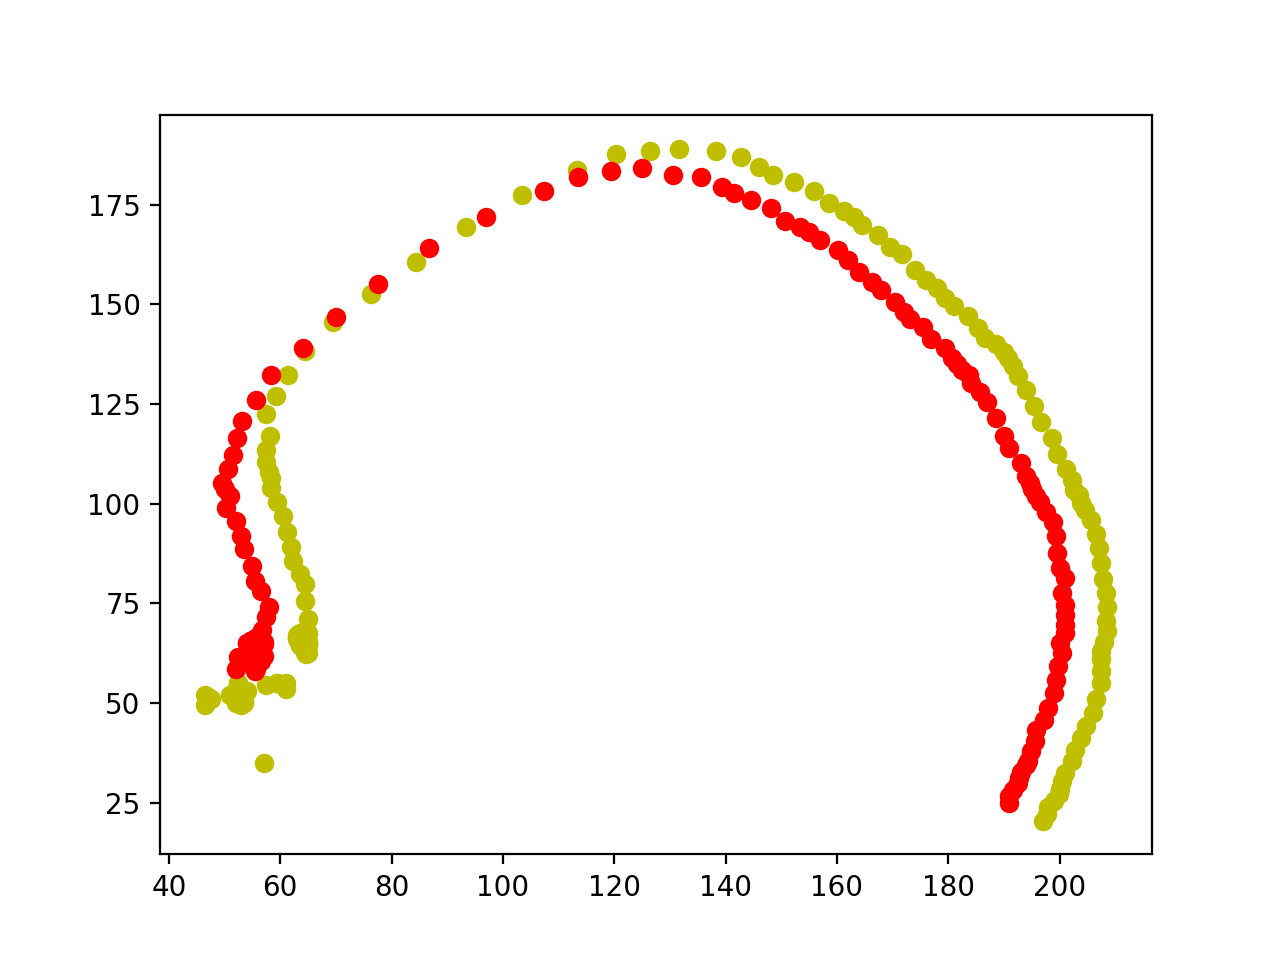

In [219]:
plt.figure()
plt.plot(x_y,y_y,'yo',x_r,y_r,'ro')
plt.show()

In [204]:
red.position[0] = [red.position[0],red.position[1]]
del red.position[1]

In [205]:
x_r = []
y_r = []
for row in red.position:
    x_r.append(row[0])
    y_r.append(row[1])
    

In [201]:
def recenter(x,y):
    """This function adjusts the x,y outputs of all tracked data and moves the origine to the center determined
    by get_center()"""
    new_x = np.zeros(np.size(x))
    new_y = np.zeros(np.size(y))
    #default origin is the upper left corner of an image.
    if frameCenter == []:
        print ('Center not found')
        cv2.imshow('Click on center',frame)
        cv2.setMouseCallback('Click on center',self.get_center)
        cv2.waitKey(5000)
    for i in range(len(x)):
        new_x[i] = x[i] - param_data['frameCenter'][0] 	#x_center,y_center are global
        new_y[i] = param_data['frameCenter'][1] - y[i]
    return new_x,new_y

In [215]:
x_r, y_r = recenter(x_r,y_r)

In [214]:
del y_r[0]; del x_r[0]